In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
plt.style.use('ggplot')

In [2]:
import pickle
with open('orfs.pickle','rb') as f:
    orfs = pickle.load(f)

orfs.head()

,start,end,length,frame,isCDS,scores
0,1,36,36,1,False,1.181405
1,40,51,12,1,False,2.758633
2,55,72,18,1,False,-2.459251
3,76,81,6,1,False,0.568646
4,85,87,3,1,False,NaN


## 2 ROC
1. Generate a single plot showing ROC curves with respect to 
    1. length threshold, say in red, and 
    2. Markov model score, say in green, 
using the full 0-1 range for both axes. 

2. Additionally, (c) generate such a plot "zoomed-in" to the upper-left corner to show the crossover between the two curves. 

For maximum clarity, you probably do not want the two axes to be equally scaled in the "zoomed" view. (Step (c) is important since there are many, many more short ORFs (mostly non-genes) than long ones (mostly real genes), which drives the ROC curves into the upper-left corner.) 

3. Also calculate and show Area Under the Curve (AUC) for each curve.

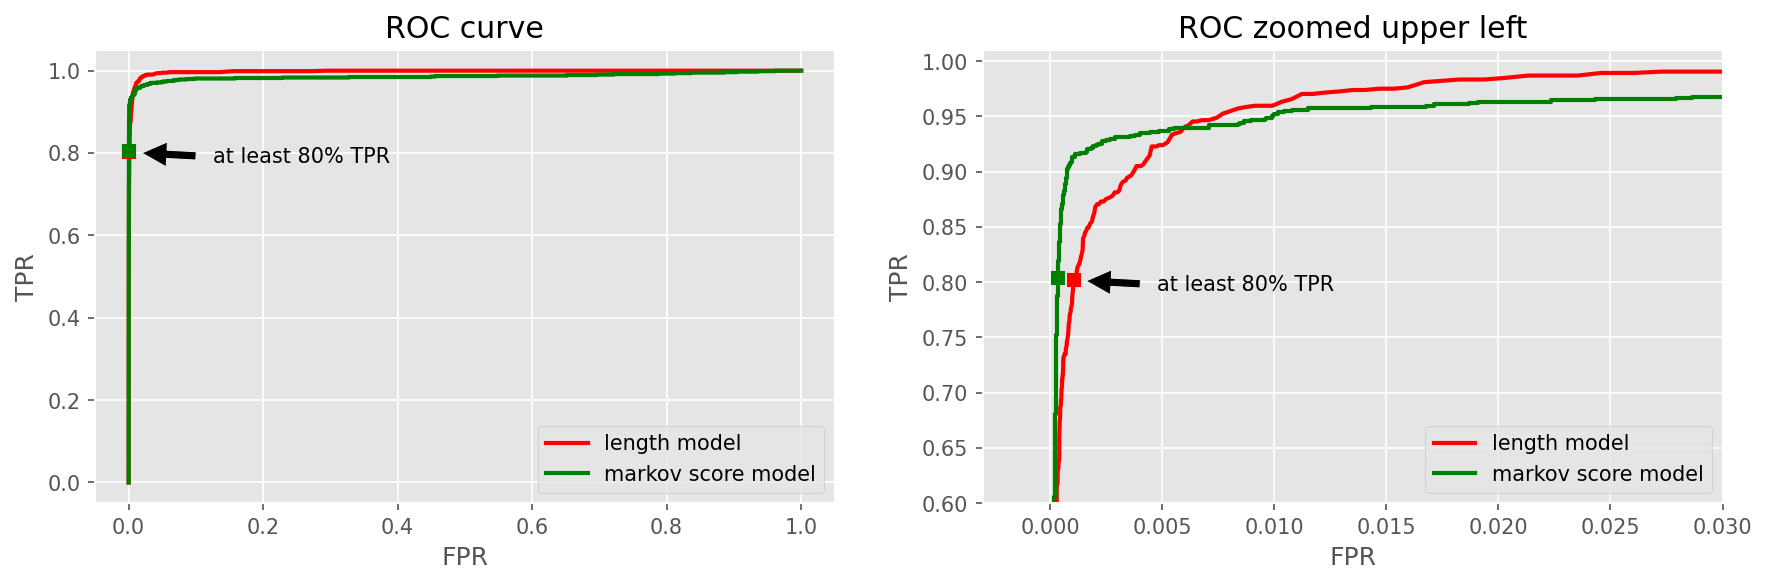

Length threshold AUC = 0.998 
Markov score AUC = 0.986


In [229]:
import sklearn.metrics
fig, axes = plt.subplots(1,2)
fig.set_figwidth(14)
score_orf = orfs.dropna()

fpr_l, tpr_l, thresholds_l = sklearn.metrics.roc_curve(score_orf.isCDS, score_orf.length)
auc_l = sklearn.metrics.auc(fpr_l, tpr_l)
fpr_s, tpr_s, thresholds_s = sklearn.metrics.roc_curve(score_orf.isCDS, score_orf.scores)
auc_s = sklearn.metrics.auc(fpr_s, tpr_s)

fig.set_dpi(150)


for ax in axes:
    ax.plot(fpr_l, tpr_l, color = 'red',lw = 2)
    ax.plot(fpr_s, tpr_s, color = 'green',lw = 2)    
    ax.legend([f'length model', f'markov score model'])
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    
    ax.plot(fpr_l[243], tpr_l[243], "s", color = "red")
    ax.plot(fpr_s[68], tpr_s[68], "s", color = "green")
    

    
    ax.annotate('at least 80% TPR',
       xy=(fpr_l[243], tpr_l[243]),
       xytext=(40, -5),    # fraction, fraction
       textcoords='offset points',
       arrowprops=dict(facecolor='black', shrink=0.15),
       clip_on=True )

    
axes[0].set_title('ROC curve')


axes[1].set_xbound(-0.003,0.03)
axes[1].set_ybound(0.6,1.01)
axes[1].set_title('ROC zoomed upper left')
plt.show()

print(f'Length threshold AUC = {auc_l:.3f} \nMarkov score AUC = {auc_s:.3f}')

## 3 
If your only option was to predict based on an ORF length threshold, what is the ~minimum~ maximum threshold that would achieve a true positive rate of at least 80%, how many true positives and how many false positives would you see using that threshold? Optionally, plot this point on the ROC curve above.


    condition positive (P)
        the number of real positive cases in the data
    condition negative (N)
        the number of real negative cases in the data
TPR = TP/P = TP/(TP+FN)

FPR = FP/N = FP/(FP+N)

In [184]:
thresholddf = pd.DataFrame({'tpr':tpr_l,'threshold':thresholds_l})
# print(score_orf[score_orf.isCDS].length.min())
# thresholddf.tail(20)

thresholddf[thresholddf['tpr'] >= 0.8].head()

,tpr,threshold
243,0.801663,432
244,0.801663,429
245,0.804038,426
246,0.807601,423
247,0.809976,420


In [204]:
pred = score_orf[score_orf.length>=432]

p = score_orf.isCDS.sum()
n = (~score_orf.isCDS).sum()
# print(len(pred))
pred.isCDS.sum() , (~pred.isCDS).sum()

(675, 102)

Maximum length threshold for at least 80% TPR = 432

using that threshold true positives =  675 and  false positives  = 102


## 4
If your only option was to predict based on a log Markov model score threshold, what is the minimum maximum threshold that would achieve a true positive rate of at least 80%, how many true positives and how many false positives would you see using that threshold? Optionally, plot this point on the ROC curve above.

In [209]:
scoredf = pd.DataFrame({'tpr':tpr_s,'threshold':thresholds_s})
scoredf[scoredf['tpr'] >= 0.8].head()

,tpr,threshold
68,0.804038,35.651812
69,0.804038,35.647811
70,0.809976,35.312610
71,0.809976,35.284226
72,0.819477,34.644724


In [206]:
pred = score_orf[score_orf.scores>=35.651812]
pred.isCDS.sum() , (~pred.isCDS).sum()

(676, 34)

Maximum length threshold for at least 80% TPR = 35.6518

using that threshold true positives =  676 and  false positives  = 34

## 5
Generate a scatter-plot of Markov model score (Y-axis) vs ORF length (X-axis) for each long and each short ORF.

Color points according to their status wrt "simple plus strand CDSs" from GenBank (true protein ORFs: orange; non-proteins: blue)

Summarize the short ORFs by the single point that falls at the median x, median y of the ORFs of length < 50. Call this point A. Likewise, summarize the long ORFs by the single point that falls at the median x, median y of the ORFs of length > 1400; call this B. Overlay your plot with some visually distinct symbol at A and B, and connect them by a straight line segment. 


 Also draw a straight line perpendicular to this line segment and crossing it at x = Ax + 0.20 * (Bx - Ax), i.e., 20% of the way from A to B. Calculate the equation of this line.

In [284]:
import numpy as np
short = score_orf[score_orf.length<50]
long = score_orf[score_orf.length>1400]
short_median_x, short_median_y = np.median(short.length), np.median(short.scores)
long_median_x, long_median_y = np.median(long.length), np.median(long.scores)


slope = (long_median_y- short_median_y)/(long_median_x-short_median_x)
intercept = long_median_y-slope*long_median_x

x = short_median_x + 0.20 * (long_median_x - short_median_x)
y = slope*x + intercept

orth_slope = -1/slope
orth_intercept = y-orth_slope*x #y-mx

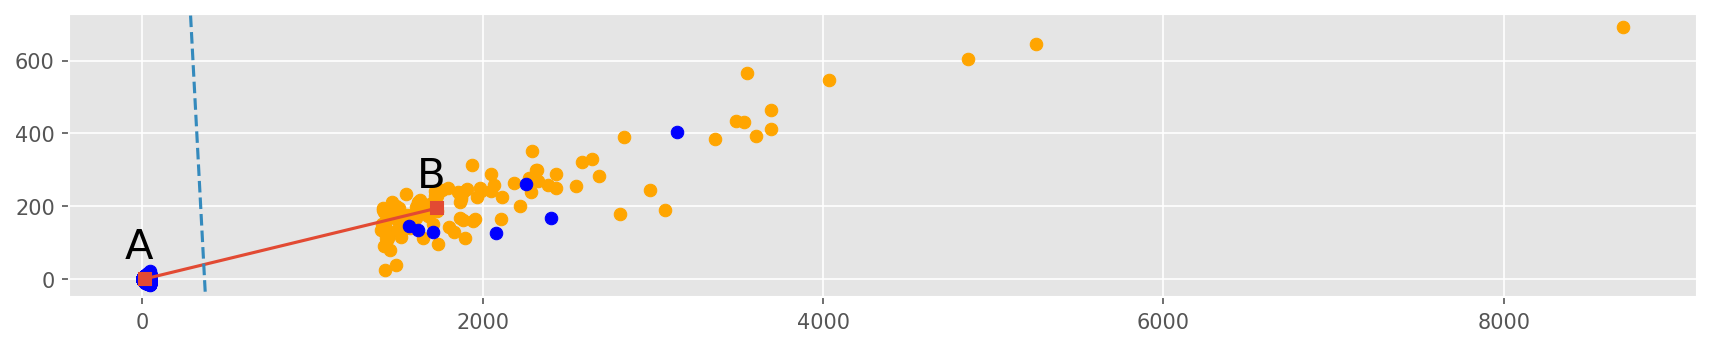

In [301]:
fig, ax = plt.subplots()
fig.set_figwidth(14)
fig.set_figheight(2.5)
fig.set_dpi(150)
for df in [short, long]:
    ax.scatter(df[df.isCDS].length, df[df.isCDS].scores, color='orange')
    ax.scatter(df[~df.isCDS].length, df[~df.isCDS].scores, color='blue')
# ax.plot(short_median_x, short_median_y, "s", color = "cyan")
# ax.plot(long_median_x, long_median_y, "s", color = "red")
ax.plot([short_median_x, long_median_x], [short_median_y, long_median_y],marker ='s')
ax.annotate('A',
   xy=(short_median_x, short_median_y),
   xytext=(-10, 10 ),    # fraction, fraction
   textcoords='offset points',
    fontsize=20,
   clip_on=True )
ax.annotate('B',
   xy=(long_median_x, long_median_y),
   xytext=(-10, 10 ),     # fraction, fraction
   textcoords='offset points',
            fontsize=20,
   clip_on=True )
xlim = ax.get_xlim()
ylim = ax.get_ylim() 
x_vals = np.array(ax.get_xlim())
y_vals = orth_intercept + orth_slope * x_vals

ax.plot(x_vals, y_vals, '--',)
ax.set_xbound(*xlim)
ax.set_ybound(*ylim)

How well does this work? Find its associated True Positive and False Positive counts and rates (on the set of all ORFs, not just the short/long training set).

Calculate distance of each point from line and plot ROC based on the